# Character Analysis in Harry Potter and the Philosopher's Stone

In this notebook, I will be using a dataset that I recently created to explore the characters in Harry Potter and the Philosopher's Stone. I'm using this as a fun way to learn some new methods including sentiment and emotion analysis.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
from collections import Counter
from wordcloud import WordCloud
from ast import literal_eval

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier


from keras import models
from keras import layers
import keras
from keras import optimizers
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Embedding

## Loading data

In [2]:
hp = pd.read_csv('hp_script.csv',encoding='cp1252')

In [3]:
hp.head()

,ID_number,scene,character_name,dialogue
0,1,1,Albus Dumbledore,"I should have known that you would be here, Pr..."
1,2,1,Minerva McGonagall,"Good evening, Professor Dumbledore. Are the ru..."
2,3,1,Albus Dumbledore,"I'm afraid so, Professor. The good, and the bad."
3,4,1,Minerva McGonagall,And the boy?
4,5,1,Albus Dumbledore,Hagrid is bringing him.


## Determining Character Importance by Number of Lines and Words of Dialogue

In [4]:
hp['character_name'].value_counts()

character_name
Harry Potter            230
Ron Weasley             120
Hermione Granger         92
Rubeus Hagrid            81
Minerva McGonagall       31
Albus Dumbledore         24
Vernon Dursley           23
Dudley Dursley           17
Quirinus Quirrell        17
Neville Longbottom       14
Petunia Dursley          13
Draco Malfoy             13
Rolanda Hooch            12
Severus Snape             9
Lee Jordan                8
Oliver Wood               8
Voldemort                 8
Sorting Hat               7
Percy Weasley             6
Argus Filch               6
Nearly Headless Nick      5
Seamus Finnigan           5
Fred Weasley              5
Firenze                   5
Molly Weasley             5
Filius Flitwick           4
George Weasley            4
Griphook                  3
Garrick Ollivander        3
Goblin                    2
Class                     2
Tom                       2
Man                       1
Marcus Flint              1
Snake                     1
The F

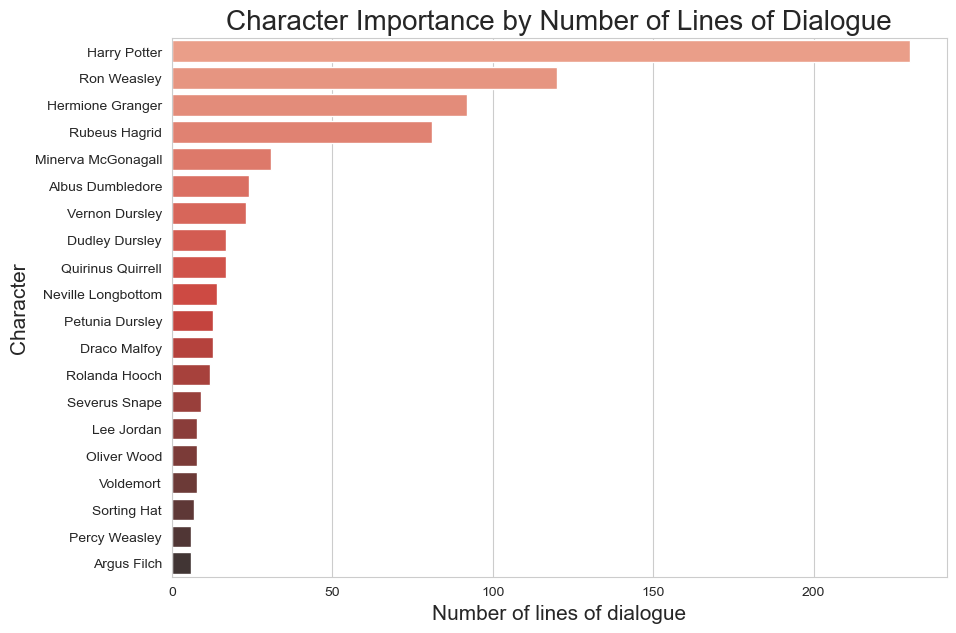

In [5]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
sns.countplot(y='character_name', data=hp, order=hp.character_name.value_counts().iloc[:20].index, palette="Reds_d")
plt.xlabel('Number of lines of dialogue', fontsize=15)
plt.ylabel('Character', fontsize=15)
plt.title('Character Importance by Number of Lines of Dialogue', fontsize=20)
plt.show()

In [6]:
# adding a new column to the dataframe, of number of words in each line
hp['dialogue_wordcount'] = hp['dialogue'].map(lambda x:len(re.findall(r'\w+', x)))

In [7]:
hp

,ID_number,scene,character_name,dialogue,dialogue_wordcount
0,1,1,Albus Dumbledore,"I should have known that you would be here, Pr...",11
1,2,1,Minerva McGonagall,"Good evening, Professor Dumbledore. Are the ru...",9
2,3,1,Albus Dumbledore,"I'm afraid so, Professor. The good, and the bad.",10
3,4,1,Minerva McGonagall,And the boy?,3
4,5,1,Albus Dumbledore,Hagrid is bringing him.,4
...,...,...,...,...,...
788,789,34,Rubeus Hagrid,"Go on. On with you, on with you now. Oh, now l...",44
789,790,34,Harry Potter,"But Hagrid, we're not allowed to do magic away...",15
790,791,34,Rubeus Hagrid,"I do, but your cousin don't, do he? Eh? Hmmhmm",11
791,792,34,Hermione Granger,"Feels strange to be going home, doesn't it?",9


In [8]:
total_char_words = hp.groupby('character_name', as_index=False).dialogue_wordcount.sum()
total_char_words = pd.DataFrame(total_char_words)
total_char_words

,character_name,dialogue_wordcount
0,Albus Dumbledore,721
1,Argus Filch,153
2,Bloody Baron,3
3,Class,7
4,Doris Crockford,14
5,Draco Malfoy,214
6,Dudley Dursley,99
7,Filius Flitwick,70
8,Firenze,114
9,Fred Weasley,41


Text(0.5, 1.0, 'Character Importance by Number of Words of Dialogue')

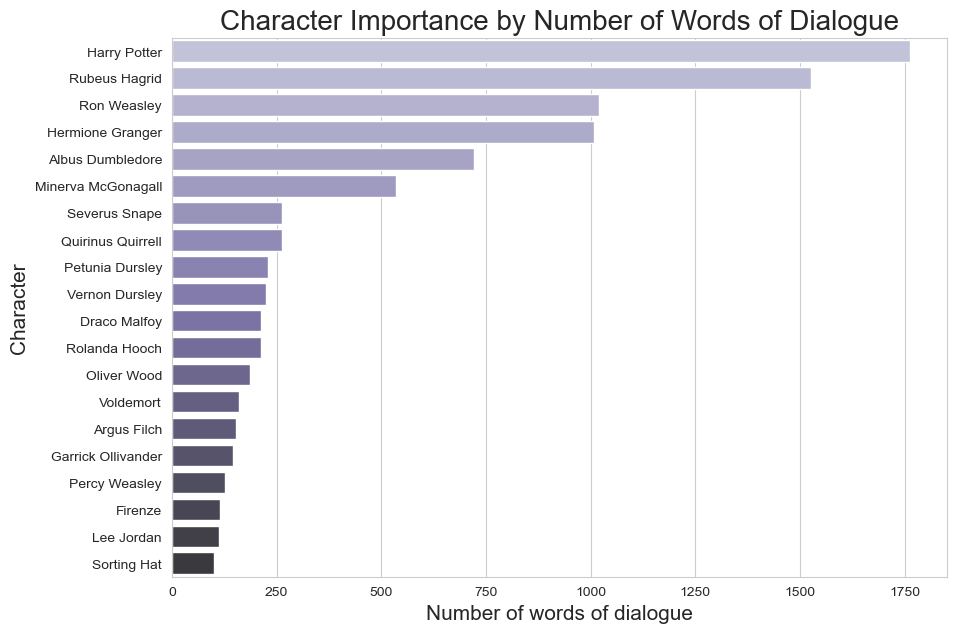

In [9]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
sns.barplot(x='dialogue_wordcount',y='character_name', data=total_char_words, palette="Purples_d", order=total_char_words.sort_values('dialogue_wordcount', ascending=False).character_name[0:20], orient='h')
plt.xlabel('Number of words of dialogue', fontsize=15)
plt.ylabel('Character', fontsize=15)
plt.title('Character Importance by Number of Words of Dialogue', fontsize=20)

## Most Commonly Used Words Overall and by Character

The following function is used to 'clean' text by removing any links, numbers, symbols and stopwords (such as 'the', 'a' etc). This is important when finding most commonly used words and when carrying out sentiment/emotion analysis as stopwords in particular would appear most often in commonly used words and they also have no sentiment.

In [10]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence = sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url = re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words = [PorterStemmer().stem(w) for w in filtered_words]
    lemma_words=[WordNetLemmatizer().lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

### Overall Most Commonly Used Words

In [13]:
# nltk.download('stopwords')
# nltk.download('wordnet')
hp['cleanText']=hp['dialogue'].map(lambda x:preprocess(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abhil\AppData\Roaming\nltk_data...


In [14]:
common_words = Counter(" ".join(hp["cleanText"]).split()).most_common(10)
common_words

[('harry', 88),
 ('know', 50),
 ('one', 48),
 ('see', 45),
 ('potter', 41),
 ('well', 41),
 ('got', 39),
 ('come', 38),
 ('right', 32),
 ('hagrid', 30)]

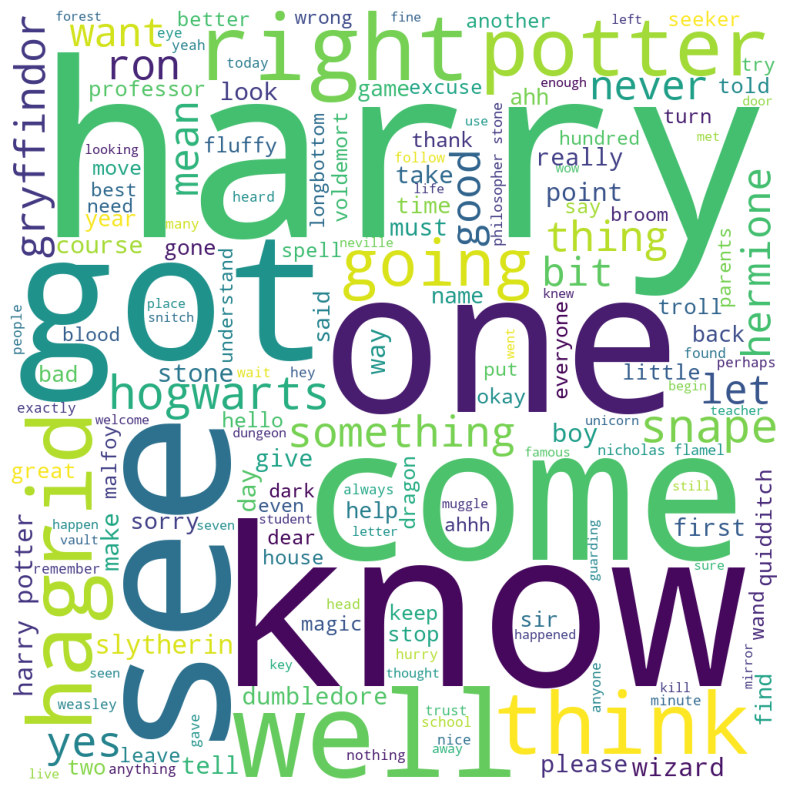

In [15]:
text = " ".join(line for line in hp["cleanText"])
wordcloud = WordCloud(width=1000, height=1000, background_color="white", min_font_size=15).generate(text)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Harry's Most Commonly Used Words

In [16]:
harry = hp[hp['character_name']=='Harry Potter']

In [17]:
common_harry = Counter(" ".join(harry["cleanText"]).split()).most_common(5)
common_harry

[('hagrid', 20), ('know', 17), ('ron', 12), ('one', 10), ('think', 10)]

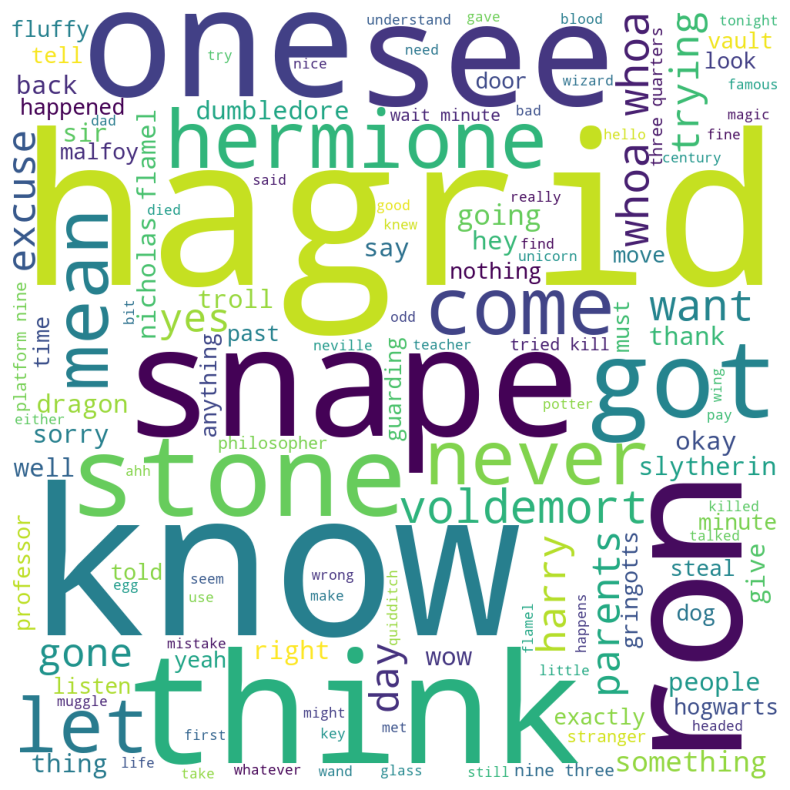

In [18]:
harry_text = " ".join(line for line in harry["cleanText"])
wordcloud = WordCloud(width=1000, height=1000, background_color="white", min_font_size=15).generate(harry_text)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Ron's Most Commonly Used Words

In [19]:
ron = hp[hp['character_name']=='Ron Weasley']

In [20]:
common_ron = Counter(" ".join(ron["cleanText"]).split()).most_common(5)
common_ron

[('harry', 17), ('got', 9), ('know', 8), ('one', 7), ('think', 7)]

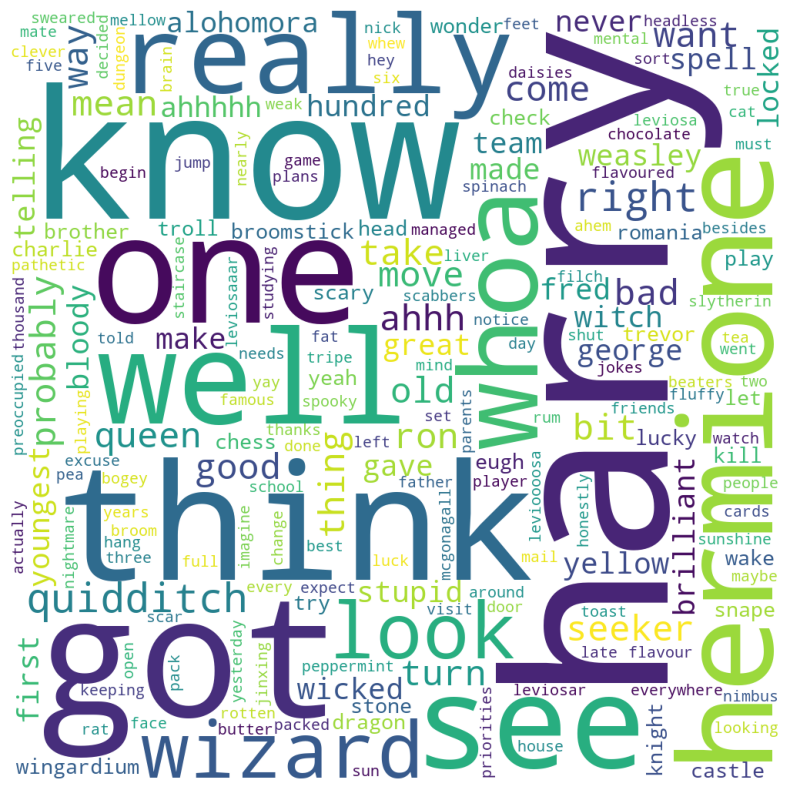

In [21]:
ron_text = " ".join(line for line in ron["cleanText"])
wordcloud = WordCloud(width=1000, height=1000, background_color="white", min_font_size=15).generate(ron_text)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Hermione's Most Commonly Used Words

In [22]:
hermione = hp[hp['character_name']=='Hermione Granger']

In [23]:
common_hermione = Counter(" ".join(hermione["cleanText"]).split()).most_common(5)
common_hermione

[('harry', 11), ('going', 7), ('know', 6), ('stone', 6), ('like', 5)]

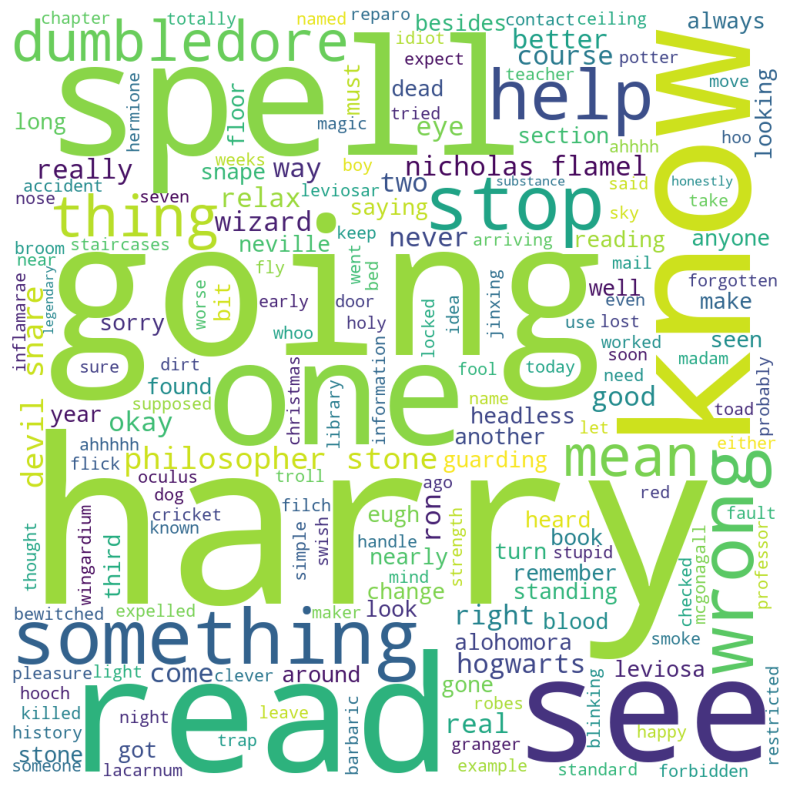

In [24]:
hermione_text = " ".join(line for line in hermione["cleanText"])
wordcloud = WordCloud(width=1000, height=1000, background_color="white", min_font_size=15).generate(hermione_text)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Sentiment analysis

Using an external dataset I will train a model to determine the sentiment of each line of dialogue from the movie. The dataset used is from Μαριος Μιχαηλιδης KazAnova on Kaggle, link: https://www.kaggle.com/kazanova/sentiment140

In [25]:
# loading the data and adjusting to provide column names

twitter = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding='cp1252', names = ['label', 'id', 'date', 'flag', 'user', 'text'])

In [26]:
twitter.head()

,label,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [27]:
# dropping irrelevant columns

twitter = twitter.drop(['id', 'date', 'flag', 'user'], axis=1)

In [28]:
# Dataset contains 1,600,000 rows. This is a very large dataset, so I will take a sample 1/4 the size of this.

twit_samp = twitter.sample(n=400000,replace=False)

In [30]:
# creating new column of clean text using previously defined function

twit_samp['cleanText']=twit_samp['text'].map(lambda x:preprocess(x))

In [28]:
# filtering data to only use tweets with more than two words after processing

twit_samp['clean_wordcount'] = twit_samp['cleanText'].map(lambda x:len(re.findall(r'\w+', x)))
filtered_twit = twit_samp[twit_samp['clean_wordcount'] > 2]

In [29]:
x_train_samp = filtered_twit['cleanText']
y_train_samp = filtered_twit['label']

In [30]:
y_train_samp = y_train_samp.replace(4,1)

In [31]:
# creating training and validation sets - 90% training, 10% validation

x_train_samp, x_valid_samp, y_train_samp, y_valid_samp = train_test_split(x_train_samp, y_train_samp, test_size=0.1)

In [32]:
# this converts the words into vectors of numbers to allow use within models

tokenizer = RegexpTokenizer(r'\w+')
vectorizer = TfidfVectorizer(ngram_range=(1, 2), tokenizer=tokenizer.tokenize)
full_text = list(x_train_samp.values) + list(x_valid_samp.values)
vectorizer.fit(full_text)
train_vectorized_samp = vectorizer.transform(x_train_samp)
test_vectorized_samp = vectorizer.transform(x_valid_samp)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [33]:
hp_vectorized = vectorizer.transform(hp['cleanText'])

In [34]:
logreg = LogisticRegression(max_iter=1000, multi_class='multinomial')

In [35]:
logreg.fit(train_vectorized_samp, y_train_samp)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [36]:
logreg.score(test_vectorized_samp, y_valid_samp)

0.7831331892660777

In [37]:
linsvc = LinearSVC(max_iter=2000)
linsvc.fit(train_vectorized_samp, y_train_samp)
linsvc.score(test_vectorized_samp, y_valid_samp)

0.7804250895861258

In [38]:
multinb = MultinomialNB()
multinb.fit(train_vectorized_samp, y_train_samp)
multinb.score(test_vectorized_samp, y_valid_samp)

0.7708509998085182

In [39]:
bernb = BernoulliNB()
bernb.fit(train_vectorized_samp, y_train_samp)
bernb.score(test_vectorized_samp, y_valid_samp)

0.7712613179418443

Both the logistic regression and linear SVC models performed quite well, with accuracies of approx 78%. To achieve a higher accuracy, a larger sample size could be used to train the model, and a neural network could be attempted, however these options would both require a more powerful laptop than what I currently have (but not for long thankfully!!).

I will use the logistic regression model to label each line of dialogue with either a 0 (negative) or 1 (positive).

In [40]:
preds = logreg.predict(hp_vectorized)

In [41]:
hp['sentiment_preds'] = preds

In [42]:
hp.head()

,ID_number,scene,character_name,dialogue,dialogue_wordcount,cleanText,sentiment_preds
0,1,1,Albus Dumbledore,"I should have known that you would be here, Pr...",11,known would professor mcgonagall,0
1,2,1,Minerva McGonagall,"Good evening, Professor Dumbledore. Are the ru...",9,good evening professor dumbledore rumours true...,1
2,3,1,Albus Dumbledore,"I'm afraid so, Professor. The good, and the bad.",10,afraid professor good bad,0
3,4,1,Minerva McGonagall,And the boy?,3,boy,1
4,5,1,Albus Dumbledore,Hagrid is bringing him.,4,hagrid bringing,1


So according to the validation accuracy, hopefully approx 78% of these lines of dialogue are corrently labelled. However, the data needs to be filtered before we go any further, as we can see above that 'boy' has been labelled as positive despite only being one word, and 'hagrid bringing' has also been labelled as positive despite being two words. It is hard to determine the correct sentiment from very few words, and therefore we can't trust these labels, so I will only consider processed text with more than two words in further analysis.

In [43]:
hp['clean_wordcount'] = hp['cleanText'].map(lambda x:len(re.findall(r'\w+', x)))
filtered_hp = hp[hp['clean_wordcount'] > 2]
filtered_hp.head()

,ID_number,scene,character_name,dialogue,dialogue_wordcount,cleanText,sentiment_preds,clean_wordcount
0,1,1,Albus Dumbledore,"I should have known that you would be here, Pr...",11,known would professor mcgonagall,0,4
1,2,1,Minerva McGonagall,"Good evening, Professor Dumbledore. Are the ru...",9,good evening professor dumbledore rumours true...,1,7
2,3,1,Albus Dumbledore,"I'm afraid so, Professor. The good, and the bad.",10,afraid professor good bad,0,4
5,6,1,Minerva McGonagall,Do you think it wise to trust Hagrid with some...,14,think wise trust hagrid something important,1,6
6,7,1,Albus Dumbledore,"Ah, Professor, I would trust Hagrid with my life.",9,professor would trust hagrid life,1,5


In [44]:
# to filter the data further, I will only analyse the top 25 characters with the most lines

char_counts = filtered_hp['character_name'].value_counts()
char_counts = char_counts[0:25]
char_counts = pd.DataFrame(char_counts)
char_counts['count'] = char_counts['character_name']
char_counts['character_name'] = char_counts.index
char_counts = char_counts.reset_index()
char_counts.drop('index', axis=1)

,character_name,count
0,Harry Potter,98
1,Rubeus Hagrid,66
2,Ron Weasley,64
3,Hermione Granger,48
4,Albus Dumbledore,21
5,Minerva McGonagall,19
6,Vernon Dursley,14
7,Quirinus Quirrell,13
8,Dudley Dursley,9
9,Draco Malfoy,9


In [45]:
filtered_hp = filtered_hp[filtered_hp.character_name.isin(char_counts['character_name'])]

In [46]:
filtered_hp.head()

,ID_number,scene,character_name,dialogue,dialogue_wordcount,cleanText,sentiment_preds,clean_wordcount
0,1,1,Albus Dumbledore,"I should have known that you would be here, Pr...",11,known would professor mcgonagall,0,4
1,2,1,Minerva McGonagall,"Good evening, Professor Dumbledore. Are the ru...",9,good evening professor dumbledore rumours true...,1,7
2,3,1,Albus Dumbledore,"I'm afraid so, Professor. The good, and the bad.",10,afraid professor good bad,0,4
5,6,1,Minerva McGonagall,Do you think it wise to trust Hagrid with some...,14,think wise trust hagrid something important,1,6
6,7,1,Albus Dumbledore,"Ah, Professor, I would trust Hagrid with my life.",9,professor would trust hagrid life,1,5


Now I will calculate the mean sentiments of each of the top 25 characters, to determine which characters are the most positive, and which are the most negative.

In [47]:
pos_neg_chars = filtered_hp.groupby('character_name', as_index=False).sentiment_preds.mean()
pos_neg_chars = pd.DataFrame(pos_neg_chars)
pos_neg_chars

,character_name,sentiment_preds
0,Albus Dumbledore,0.523810
1,Argus Filch,0.666667
2,Draco Malfoy,0.444444
3,Dudley Dursley,0.333333
4,Filius Flitwick,1.000000
5,Firenze,0.500000
6,Fred Weasley,0.750000
7,Harry Potter,0.520408
8,Hermione Granger,0.541667
9,Lee Jordan,1.000000


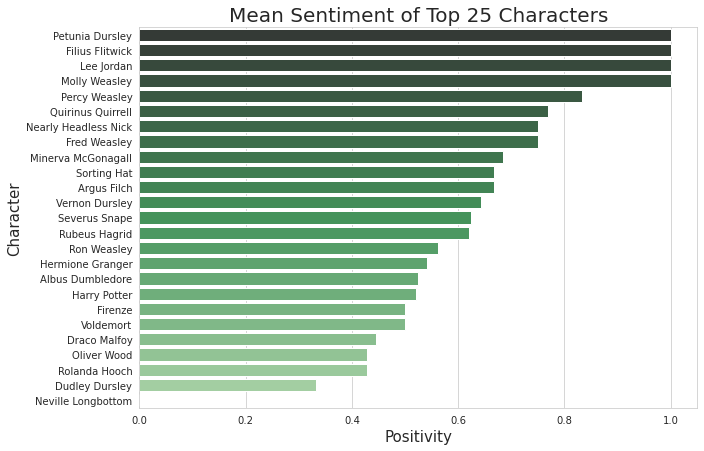

In [48]:
plt.figure(figsize=(10,7))
sns.barplot(x='sentiment_preds', y='character_name', data=pos_neg_chars, palette="Greens_d", order=pos_neg_chars.sort_values('sentiment_preds', ascending=False).character_name[0:25], orient='h')
plt.xlabel('Positivity', fontsize=15)
plt.ylabel('Character', fontsize=15)
plt.title('Mean Sentiment of Top 25 Characters', fontsize=20)
plt.show()

According to this graph, the most positive characters are Flitwick, Petunia and Lee Jordan with 100% positivity. At first I questioned Petunia's results, but looking at her dialogue, her vocabulary actually is mostly positive. On the other hand, the most negative characters are Dudley, Draco and Neville. 5 characters have roughly 50% positivity: Firenze, Harry, Filch, Hermione and Dumbledore. Firenze, Hermione and Dumbledore are all very wise characters with realistic points of view, so their results make sense as they are equally positive and negative. Some questionable results are those of Voldemort and Snape who both come across as negative characters in the movie, but all got highly positive results.

Combining the script of this movie with scripts from other movies in the series could result in more accurate results for less important characters, provided those characters are in the other movies and that there are no major changes in the characters from one movie to the next. I might try this with the Chamber of Secrets script next!

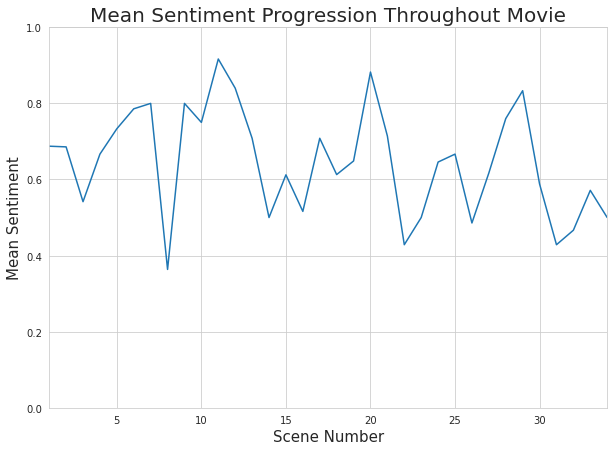

In [49]:
scene_sent = pd.DataFrame(hp.groupby('scene', as_index=False).sentiment_preds.mean())
plt.figure(figsize=(10,7))
sns.lineplot(x="scene", y="sentiment_preds", data=scene_sent)
plt.xlabel('Scene Number', fontsize=15)
plt.ylabel('Mean Sentiment', fontsize=15)
plt.title('Mean Sentiment Progression Throughout Movie', fontsize=20)
plt.ylim(0,1)
plt.xlim(1,34)
plt.show()

This graph shows that the most negative point in the movie was scene 8. This scene involves Hagrid telling Harry the story of how his parents died and how he got the scar on his forehead, undoubtedly a very negative scene! However, it also shows that the most positive point was scene 29 - in this scene Ron sacrifices himself in the game of wizards' chess, which definitely isn't a positive scene. This shows that the model could benefit from some serious improvements.

## Emotion Analysis

In this section a new dataset was used, which also consists of tweets but instead of having sentiment labels 0 or 1, it has 13 emotions. Link: https://www.kaggle.com/icw123/emotion

In [50]:
emotions = pd.read_csv('text_emotion.csv')
emotions = emotions.drop(columns = ['tweet_id', 'author'])
emotions.groupby('sentiment').count()

,content
sentiment,
anger,110
boredom,179
empty,827
enthusiasm,759
fun,1776
happiness,5209
hate,1323
love,3842
neutral,8638


In [51]:
# due to the very small number of anger and boredom tweets in comparison to the other emotions, I will remove these tweets

emotions = emotions[emotions.sentiment.isin({'empty', 'enthusiasm', 'fun', 'happiness', 'hate', 'love', 'neutral', 'relief', 'sadness', 'surprise', 'worry'})]

In [52]:
# converting each emotion to an integer

emotions['sentiment'] = emotions['sentiment'].map({'empty':0, 'enthusiasm':1, 'fun':2, 'happiness':3, 'hate':4, 'love':5, 'neutral':6, 'relief':7, 'sadness':8, 'surprise':9, 'worry':10})
emotions.head()

,sentiment,content
0,0,@tiffanylue i know i was listenin to bad habi...
1,8,Layin n bed with a headache ughhhh...waitin o...
2,8,Funeral ceremony...gloomy friday...
3,1,wants to hang out with friends SOON!
4,6,@dannycastillo We want to trade with someone w...


In [53]:
emotions['cleanText']=emotions['content'].map(lambda x:preprocess(x))

In [54]:
x_train2 = emotions['cleanText']
y_train2 = emotions['sentiment']

In [55]:
x_vectorized = vectorizer.transform(x_train2)

As the data is very imbalanced (759 enthusiasm tweets vs 8638 neutral) this can negatively affect the training of the model. Therefore I will use SMOTE to resample the data so that each emotion has an equal number of tweets. Regular resampling can result in overfitting, as the model will be trained on identical rows of data many times, whereas SMOTE involves the creation of new, synthetic data which is based on the existing data, so it will be similar but not identical. This helps to avoid overfitting.

In [56]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(x_vectorized, y_train2)

In [57]:
train2_vectorized, test2_vectorized, y_train2, y_valid2 = train_test_split(x_smote, y_smote, test_size=0.1)

In [58]:
logreg2 = LogisticRegression(max_iter=500)
logreg2.fit(train2_vectorized, y_train2)
logreg2.score(test2_vectorized, y_valid2)

0.6528099347505788

In [59]:
linsvc2 = LinearSVC(max_iter=800)
linsvc2.fit(train2_vectorized, y_train2)
linsvc2.score(test2_vectorized, y_valid2)

0.7620500947169017

In [60]:
multinb2 = MultinomialNB()
multinb2.fit(train2_vectorized, y_train2)
multinb2.score(test2_vectorized, y_valid2)

0.7136392338455062

Linear SVC gives the best accuracy of these three models.

In [61]:
preds2 = linsvc2.predict(hp_vectorized)

In [62]:
hp['emotion_preds'] = preds2

In [63]:
hp['emotion_preds'] = hp['emotion_preds'].map({0:'empty', 1:'enthusiasm', 2:'fun', 3:'happiness', 4:'hate', 5:'love', 6:'neutral', 7:'relief', 8:'sadness', 9:'surprise', 10:'worry'})

Text(0, 0.5, 'Emotion')

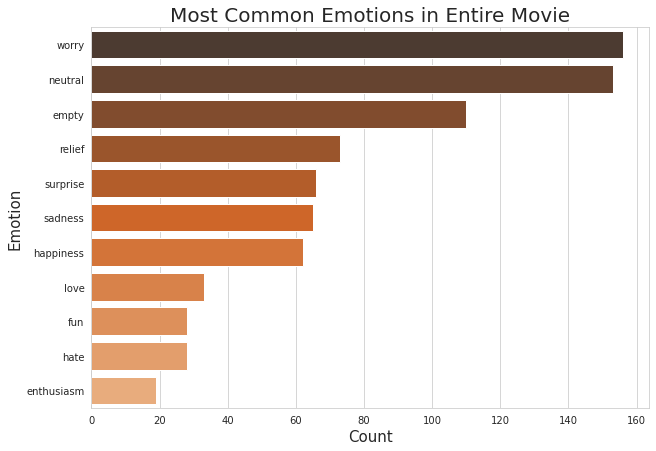

In [64]:
total_emotions = pd.DataFrame(hp.groupby('emotion_preds', as_index=False).ID_number.count())
total_emotions = total_emotions.sort_values('ID_number', ascending=False)
plt.figure(figsize=(10,7))
sns.barplot(y='emotion_preds', x='ID_number', data=total_emotions, palette="Oranges_d", orient='h')
plt.title('Most Common Emotions in Entire Movie', fontsize=20)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Emotion', fontsize=15)

Neutral and worry are the two most common emotions in the movie, whereas fun and enthusiasm are the least common. These were also two of the least common emotions in the training set so these results may not be accurate and may be a result of the dataset being imbalanced, despite having used SMOTE.

### Most common emotions of some of the main characters

Text(0, 0.5, 'Emotion')

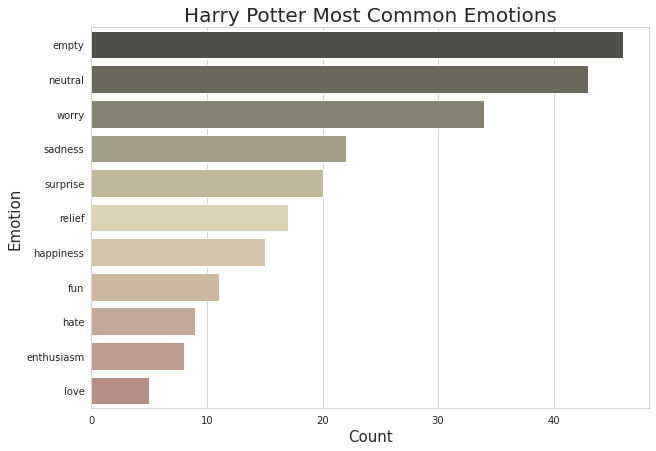

In [65]:
char_emotions = pd.DataFrame(hp.groupby('character_name').emotion_preds.value_counts())
char_emotions = char_emotions.rename(columns={'emotion_preds': 'counts'})
char_emotions = char_emotions.reset_index()
plt.figure(figsize=(10,7))
sns.barplot(y='emotion_preds', x='counts', data=char_emotions[char_emotions['character_name']=='Harry Potter'], palette='pink_d')
plt.title('Harry Potter Most Common Emotions', fontsize=20)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Emotion', fontsize=15)

Text(0, 0.5, 'Emotion')

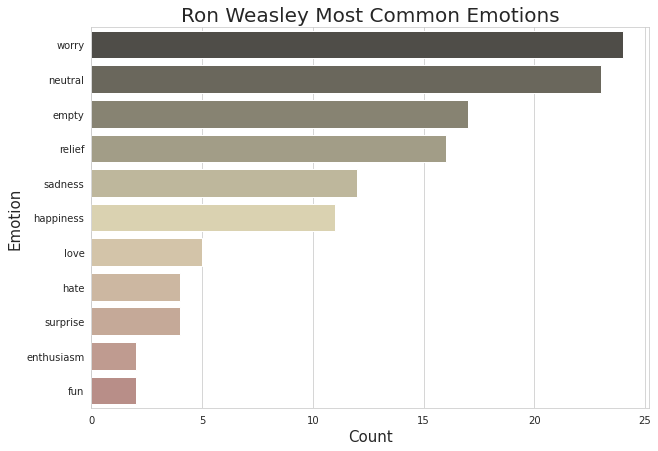

In [66]:
char_emotions = pd.DataFrame(hp.groupby('character_name').emotion_preds.value_counts())
char_emotions = char_emotions.rename(columns={'emotion_preds': 'counts'})
char_emotions = char_emotions.reset_index()
plt.figure(figsize=(10,7))
sns.barplot(y='emotion_preds', x='counts', data=char_emotions[char_emotions['character_name']=='Ron Weasley'], palette='pink_d')
plt.title('Ron Weasley Most Common Emotions', fontsize=20)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Emotion', fontsize=15)

Text(0, 0.5, 'Emotion')

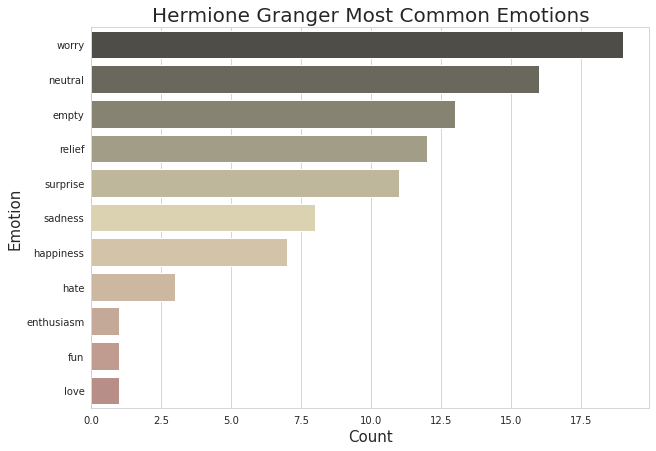

In [67]:
char_emotions = pd.DataFrame(hp.groupby('character_name').emotion_preds.value_counts())
char_emotions = char_emotions.rename(columns={'emotion_preds': 'counts'})
char_emotions = char_emotions.reset_index()
plt.figure(figsize=(10,7))
sns.barplot(y='emotion_preds', x='counts', data=char_emotions[char_emotions['character_name']=='Hermione Granger'], palette='pink_d')
plt.title('Hermione Granger Most Common Emotions', fontsize=20)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Emotion', fontsize=15)

Text(0, 0.5, 'Emotion')

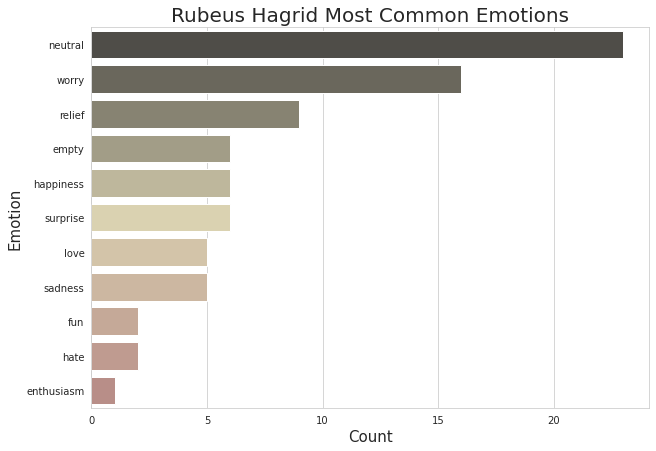

In [68]:
char_emotions = pd.DataFrame(hp.groupby('character_name').emotion_preds.value_counts())
char_emotions = char_emotions.rename(columns={'emotion_preds': 'counts'})
char_emotions = char_emotions.reset_index()
plt.figure(figsize=(10,7))
sns.barplot(y='emotion_preds', x='counts', data=char_emotions[char_emotions['character_name']=='Rubeus Hagrid'], palette='pink_d')
plt.title('Rubeus Hagrid Most Common Emotions', fontsize=20)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Emotion', fontsize=15)

Text(0, 0.5, 'Emotion')

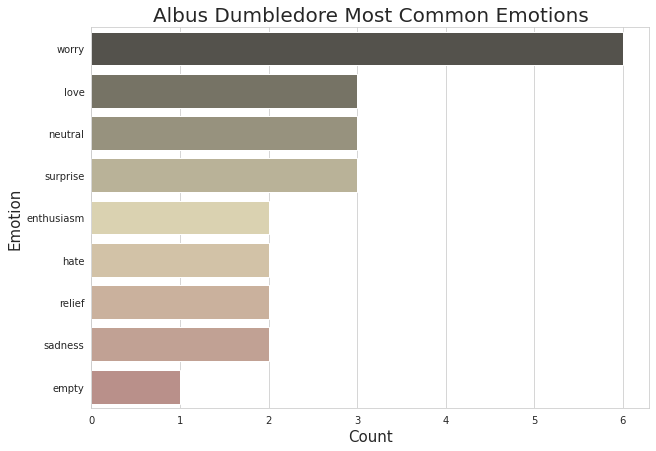

In [69]:
char_emotions = pd.DataFrame(hp.groupby('character_name').emotion_preds.value_counts())
char_emotions = char_emotions.rename(columns={'emotion_preds': 'counts'})
char_emotions = char_emotions.reset_index()
plt.figure(figsize=(10,7))
sns.barplot(y='emotion_preds', x='counts', data=char_emotions[char_emotions['character_name']=='Albus Dumbledore'], palette='pink_d')
plt.title('Albus Dumbledore Most Common Emotions', fontsize=20)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Emotion', fontsize=15)

Unsurprisingly, the most common emotion of each of these characters is in the top 2 overall most common emotions of the movie. However, Dumbledore's most common emotion, worry, leads by a huge amount, as does Hagrid's most common emotion, neutral.

Thank you for taking the time to look at this notebook. I know it doesn't have much structure and really it's just me messing around and experimenting with the data and some new methods that I wasn't previously familiar with! I still see myself as a beginner so any suggestions on how to improve any of this would be very much appreciated! I plan to expand on this in the future, and add some other datasets in to explore character development and improve accuracy.